In [59]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from datetime import datetime
from pprint import pprint

#Crimes_2012-2015
#https://catalog.data.gov/dataset/crimes-2012-2015

# 935259 Rows
# 2012 - 2015
#Header = Date.Rptd, DR.NO,DATE.OCC,TIME.OCC,AREA,AREA.NAME,RD,Crm.Cd,CrmCd.Desc,Status,Status.Desc,
#            LOCATION,Cross.Street,Location.1
#AREA.NAME = districten

years =[]

#import dataset (pas locatie aan)
#filter header eruit
crime_data = (sc.textFile('../data/crimesLA/Crimes_2012-2015.csv').filter(lambda line: 'DATE.OCC' not in line))

year12 = crime_data.filter(lambda line: '/2012'  in line)
year13 = crime_data.filter(lambda line: '/2013'  in line)
year14 = crime_data.filter(lambda line: '/2014'  in line)
year15 = crime_data.filter(lambda line: '/2015'  in line)

years.append(year12)
years.append(year13)
years.append(year14)
years.append(year15)

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

# x_axis = [ for i in range(12, 16, 1)]

x_axis = range(2012,2016)
y_axis = []

for i in range(0, 4):
    y_axis.append(years[i].count())
    print years[i].count()

238117
239731
240449
228443


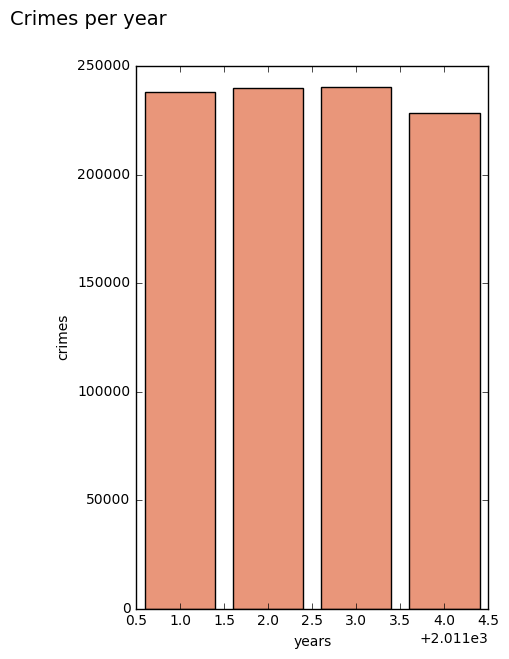

In [61]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Crimes per year', fontsize=14)
ax = fig.add_subplot(122)
ax.set_xlabel('years')
ax.set_ylabel('crimes')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

In [62]:
# year12CrimesId = []
# def filterCrimesId(line):
#     raw = line.split(';')
#     year12CrimesId.append(int(raw[7]))
        
                          
                          
# # year12.filter(line in line).map(filterCrimesId)
# year12CrimesId.append(year12.map(word in line)[8])
                          

# print years12CrimesId.take(5)                          

In [ ]:
personCrimesid = [

if 
    952,231,230,624,622,623,860,840,870,235,627,813,237,922,812,110,930,943,753,886,434,111,830,940,236,626,763,250,251,821,845,810,815,850,910,882,884,435,820,933,625,888,756,113,121,932,762]
personCrimes = 0


for j in range(0, len(personCrimesid)):
    amount = year12.filter(lambda line: str(personCrimesid[j]) in line).count()
    print str(amount)
    personCrimes+= amount
    
print personCrimes

1637
3768
20618
21075
1778
2719
2635
2438


In [98]:
personCrimesid = [952,231,230,624,622,623,860,840,870,235,627,813,237,922,812,110,930,943,753,886,434,111,830,940,236,626,
                763,250,251,821,845,810,815,850,910,882,884,435,820,933,625,888,756,113,121,932,762]
propertyCrimesid = [648,480,487,942,949,662,664,310,330,654,653,660,951,950,345,444,668,670,349,347,924,331,420,354,440,473,474,350,341,647,470,471,740,745,510,442,
                    343,430,431,446,352,805,661,210,351,931]
inchoateCrimesid = [220,485,761,666,320,410,944,954,445,421,450,441,475,520,443,920,452,436,451,122,928,930]
statutoryCrimesid = [948,755,903,880,649,652,651,433,865,353,439,900,901,902,806,437,438,956,946,814,822]
traficCrimesid = [997,890]
personCrimes = 0
test = ""

def parse_interaction(line):
    elems = line.split(",")
    if elems[7] in personCrimesid:
        return ("personCrimes", elems)
    elif elems[7] in propertyCrimesid:
        return ("propertyCrimes", elems)
    elif elems[7] in inchoateCrimesid:
        return ("inchoateCrimes", elems)
    elif elems[7] in statutoryCrimesid:
        return ("statutoryCrimes", elems)
    elif elems[7] in traficCrimesid:
        return ("traficCrimes", elems)
    else:
        return (elems[7], None)

key_csv_data = year12.map(parse_interaction)
print key_csv_data.distinct().collect()

year12split = year12.map(lambda x: x.split(","))
print year12split.take(1)[0][7]

# year12vars = year12split.filter(lambda x: x for i in personCrimesid if x[7] == i)
# print year12vars.count()

# year12split = year12.map(lambda x: x.split(","))
# year12Vars = []
# normal_csv_data = csv_data.filter(lambda x: x[7]=="886").count()

# for j in range(0, len(personCrimesid)):
#     amount = year12split.filter(lambda line: line[7]==str(personCrimesid[j])).count()
#     print str(amount)
#     personCrimes += amount

# for j in range(0, len(personCrimesid)):
#     dataLine = year12split.filter(lambda line: if line[7]==str(personCrimesid[j])).collect()
#     try:
#         print dataLine.take(1)
#     except: 
#         pass
#     year12Vars.append(dataLine)

# print year12Vars


[(u'121', None), (u'668', None), (u'648', None), (u'231', None), (u'345', None), (u'487', None), (u'343', None), (u'440', None), (u'860', None), (u'122', None), (u'438', None), (u'930', None), (u'740', None), (u'320', None), (u'884', None), (u'251', None), (u'902', None), (u'110', None), (u'950', None), (u'956', None), (u'353', None), (u'745', None), (u'910', None), (u'649', None), (u'230', None), (u'820', None), (u'451', None), (u'954', None), (u'651', None), (u'250', None), (u'330', None), (u'520', None), (u'220', None), (u'806', None), (u'341', None), (u'922', None), (u'442', None), (u'444', None), (u'654', None), (u'622', None), (u'951', None), (u'624', None), (u'944', None), (u'932', None), (u'310', None), (u'805', None), (u'410', None), (u'886', None), (u'435', None), (u'441', None), (u'940', None), (u'920', None), (u'888', None), (u'946', None), (u'354', None), (u'331', None), (u'437', None), (u'625', None), (u'821', None), (u'443', None), (u'813', None), (u'761', None), (u'623'

In [14]:
propertyCrimesid = [648,480,487,942,949,662,664,310,330,654,
                    653,660,951,950,345,
                    444,668,670,349,347,924,331,
                    420,354,440,473,474,350,
                    341,647,470,471,740,745,510,442,
                    343,430,431,446,352,805,661,210,351,931]
# propertyCrimesid.sort()
# print propertyCrimesid
propertyCrimes = 0

for j in range(0, len(propertyCrimesid)):
    amount = year12.filter(lambda line: str(personCrimesid[j]) in line).count()
    print str(amount)
    propertyCrimes+= amount
    
print propertyCrimes

[210, 310, 330, 331, 341, 343, 345, 347, 349, 350, 351, 352, 354, 420, 430, 431, 440, 442, 444, 446, 470, 471, 473, 474, 480, 487, 510, 647, 648, 653, 654, 660, 661, 662, 664, 668, 670, 740, 745, 805, 924, 931, 942, 949, 950, 951]


In [ ]:
propertyCrimesid = [648,480,487,942,949,662,664,310,330,654,
                    653,660,951,950,345,
                    444,668,670,349,347,924,331,
                    420,354,440,473,474,350,
                    341,647,470,471,740,745,510,442,
                    343,430,431,446,352,805,661,210,351,931]
# propertyCrimesid.sort()
# print propertyCrimesid
propertyCrimes = 0

for j in range(0, len(propertyCrimesid)):
    amount = year12.filter(lambda line: str(personCrimesid[j]) in line).count()
    print str(amount)
    propertyCrimes+= amount
    
print propertyCrimes

In [ ]:
inchoateCrimesid = [220,485,761,666,320,410,944,954,445,421,450,441,475,520,443,920,452,436,451,122,928,930]
# inchoateCrimesid.sort()
# print propertyCrimesid
inchoateCrimes = 0

for j in range(0, len(inchoateCrimesid)):
    amount = year12.filter(lambda line: str(inchoateCrimesid[j]) in line).count()
    print str(amount)
    inchoateCrimes+= amount
    
print inchoateCrimes

In [18]:
statutoryCrimesid = [948,755,903,880,649,652,651,433,865,353,439,900,901,902,806,437,438,956,946,814,822]
# statutoryCrimesid.sort()
# print statutoryCrimesid
statutoryCrimes = 0

for j in range(0, len(statutoryCrimesid)):
    amount = year12.filter(lambda line: str(statutoryCrimesid[j]) in line).count()
    print str(amount)
    statutoryCrimes+= amount
    
print statutoryCrimes

[353, 433, 437, 438, 439, 649, 651, 652, 755, 806, 865, 880, 900, 901, 902, 903, 948]


In [ ]:
traficCrimesid = [997,890]
# statutoryCrimesid.sort()
# print statutoryCrimesid
traficCrimes = 0

for j in range(0, len(traficCrimesid)):
    amount = year12.filter(lambda line: str(traficCrimesid[j]) in line).count()
    print str(amount)
    traficCrimes+= amount
    
print traficCrimes

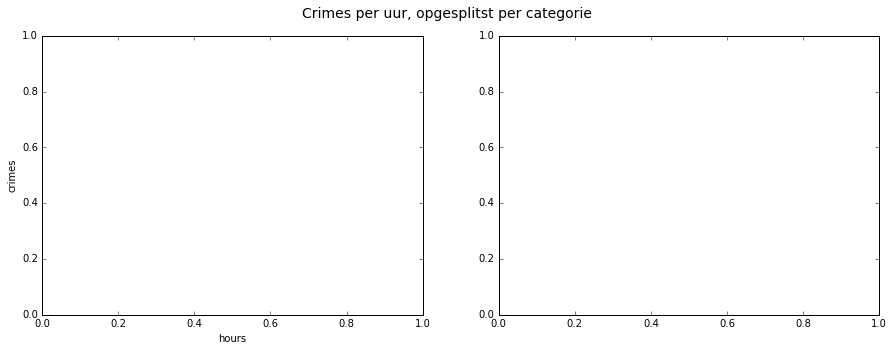

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

x_axis = range(0,24)
y_axis = []

fig = plt.figure(figsize=(15, 5))
plt1 = fig.add_subplot(121)
fig.suptitle('Crimes per uur, opgesplitst per categorie', fontsize=14)
plt1.set_xlabel('hours')
plt1.set_ylabel('crimes')
#plt1.plot(hours, traficCrimes)
plt2 = fig.add_subplot(122)
#plt2.plot(hours, statutoryCrimes)

In [82]:
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *
# from datetime import datetime

# #Crimes_2012-2015
# #https://catalog.data.gov/dataset/crimes-2012-2015

# # 935259 Rows
# # 2012 - 2015
# #Header = Date.Rptd, DR.NO,DATE.OCC,TIME.OCC,AREA,AREA.NAME,RD,Crm.Cd,CrmCd.Desc,Status,Status.Desc,
# #            LOCATION,Cross.Street,Location.1
# #AREA.NAME = districten

# YEARS = [2012, 2013, 2014, 2015]
# crime_data = []

# #import dataset (pas locatie aan)
# #filter header eruit
# # crime_data = (sc.textFile('../data/crimesLA/Crimes_2012-2015.csv').filter(lambda l: 'DATE.OCC' not in l))

# # convert to a dataframe
# def convert_to_df(year):
# #     if year == '2015-01':
# #         separator = '\t'
# #     else:
# #         separator = ';'
#     seperator = ";"
#     crime_data = sc.textFile('../Crimes_2012-2015.csv')
#     year_rdd = (crime_data
#                     .filter(lambda l: 'DATE.OCC' not in l)
#                     .filter(lambda l: '/' + year in l)
#                     .map(lambda l: add_fields(l, separator))
#                )
    
#     # apply the schema to the RDD.
#     year_df = sqlContext.createDataFrame(year_rdd, schema)
    
#     return year_df

# fields = []
# fields.append(StructField('DateReported', DateType(), True))
# fields.append(StructField('Docnr', IntegerType(), True))
# fields.append(StructField('DateOccupied', DateType(), True))
# fields.append(StructField('areaId', IntegerType(), True))
# fields.append(StructField('areaName', StringType(), True))
# fields.append(StructField('rd', IntegerType(), True))
# fields.append(StructField('crimeId', IntegerType(), True))
# fields.append(StructField('crimeName', StringType(), True))
# fields.append(StructField('statusId', IntegerType(), True))
# fields.append(StructField('statusName', StringType(), True))
# fields.append(StructField('location', StringType(), True))
# fields.append(StructField('crossStreet', StringType(), True))
# fields.append(StructField('location_type', StringType(), True))
# schema = StructType(fields)


        

# fields = []
# fields.append(StructField('DateReported', DateType(), True))
# fields.append(StructField('Docnr', IntegerType(), True))
# fields.append(StructField('DateOccupied', DateType(), True))
# fields.append(StructField('areaId', IntegerType(), True))
# fields.append(StructField('areaName', StringType(), True))
# fields.append(StructField('rd', IntegerType(), True))
# fields.append(StructField('crimeId', IntegerType(), True))
# fields.append(StructField('crimeName', StringType(), True))
# fields.append(StructField('statusId', IntegerType(), True))
# fields.append(StructField('statusName', StringType(), True))
# fields.append(StructField('location', StringType(), True))
# fields.append(StructField('crossStreet', StringType(), True))
# fields.append(StructField('lat', FloatType(), True))
# fields.append(StructField('long', FloatType(), True))
# schema = StructType(fields)




# def add_fields(line, separator):
#     fields = []
#     vals = line.split(separator)
#     # DateReported
#     date = datetime.strptime(vals[0], '%m/%d/%Y')
#     fields.append(date)
#     # Docnr
#     fields.append(int(vals[2]))
#     # DateOccupied
#     date = datetime.strptime(vals[3], '%m/%d/%Y')
#     fields.append(date)
#     # areaId
#     fields.append(int(vals[4]))
#     # areaName
#     fields.append(vals[3])
#     # rd
#     fields.append(int(vals[5]))
#     # crimeId
#     fields.append(int(vals[6]))
#     # crimeName
#     fields.append(vals[7])
#     # statusId
#     fields.append(int(vals[8]))
#     # statusName
#     fields.append(vals[9])
#     # location
#     fields.append(vals[10])
#     # crossStreet
#     fields.append(vals[11])
#     # lat
#     fields.append(vals[12][2:])
#     # longit
#     fields.append(vals[12][:-2])
    
    
#     return fields
# zz